### Imports 

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
import torch.nn as nn
import pickle
import sys
import imp
from scipy import stats

sys.path.append('../')
%matplotlib inline

In [6]:
from cvar_helpers import calc_cvar_from_quantiles
from cvar_helpers import calc_cvar_from_samples
from cvar_sampler import distort_probabilities
from rl_learner import TD_Learner
from generate_sentences_w_cvar import score_sentiment

### Code

In [172]:
def load_distributions(folder = 'single_sentences_IYou_3',
                       alphas = [0.05, 0.2, 0.3, 0.5],
                       top_k =10,
                       extra = '_prompt_enc',
                       prompt = '',
                       legacy=True, # stored outside or inside the folder of the quantile model
                       quantile_learner='quantile_learner_104_0.1_prompt_enc',
                       seed='',
                       absol='',
                       ):
    
    # load training corpus
    corpus_file = '../data/results/'+folder+'/full_generations.txt'    
    f = open(corpus_file, "r")
    sentences = f.readlines()
    sentences = np.array([s.replace('\n','') for s in sentences])
    rewards =  np.array([float(s.split('r=')[-1]) for s in sentences])

    corpus_file2 = '../data/results/'+folder+'/ends.txt'    
    f = open(corpus_file2, "r")
    ends = f.readlines()
    ends = np.array([s.replace('\n','').split('r=')[0].strip() for s in ends])
    
    # load new generations
    sentences_cvar = {}
    rewards_cvar = {}

    for alpha in alphas:
        
        if legacy:
            file = f'../data/results/'+folder+f'/ends_cvar_{alpha}_{top_k}{extra}_unres{prompt}{seed}{absol}.txt'
        else:
            file = f'../data/results/'+folder+f'/{quantile_learner}/ends_cvar_{alpha}_{top_k}{extra}_unres{prompt}{seed}{absol}.txt'
        
        f = open(file, "r")

        sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])

        rewards_cvar[alpha] =  []
        for s in sentences_cvar[alpha]:
            try:
                r = float(s.split('r=')[-1])
                rewards_cvar[alpha].append(r)
            except:
                rewards_cvar[alpha].append(np.nan)
        rewards_cvar[alpha]=np.array(rewards_cvar[alpha])
        
        
    # load extra details related to
    alpha_storage = {}
    p_storage = {}
    pd_storage = {}
    sentences_storage = {}
    sentences_storage_full = {}
    rewards_storage = {}
    token_storage = {}
    cvar_storage = {}
    prompt_storage = {}
    quantile_storage = {}
    success_storage = {}

    for alpha in alphas:
    
        if legacy:
            file = f'../data/results/'+folder+f'/cvar_output_{alpha}_{top_k}{extra}_unres{prompt}{seed}{absol}.pkl'
        else:
            file = f'../data/results/'+folder+f'/{quantile_learner}/cvar_output_{alpha}_{top_k}{extra}_unres{prompt}{seed}{absol}.pkl'

        loaded = pickle.load(open(file,'rb'))
        alpha_storage[alpha] = loaded['alphas']
        p_storage[alpha] = loaded['p_storage']
        pd_storage[alpha] = loaded['pd_storage']
        sentences_storage[alpha] = loaded['sentences']
        sentences_storage_full[alpha] = loaded['sentences_full']
        rewards_storage[alpha] = loaded['rewards']
        token_storage[alpha] = loaded['token_storage']
        cvar_storage[alpha] = loaded['cvar_storage']
        quantile_storage[alpha] = loaded['quantile_storage']
        prompt_storage[alpha]= loaded['prompt_storage']
        success_storage[alpha] = loaded['successes']

    return(sentences, ends, rewards, sentences_cvar, rewards_cvar, 
           sentences_storage, sentences_storage_full, rewards_storage)

In [170]:
def plot_single_distribution(alpha, rewards_cvar):
    
    xtick_fsize = 14
    ylabel_pad = 60
    plt.figure(figsize=(8, 2.5), dpi=200)
    
    
    plt.hist(rewards_cvar[alpha], alpha=1, color=sns.color_palette()[0],
             label=None,density=False, edgecolor='k',linewidth=0.1)

    mean = np.nanmean(rewards_cvar[alpha])
    plt.axvline(x=mean, color='k')
    
    plt.xlim([-1,1])
    plt.ylabel(f'alpha={alpha}',rotation=0,fontsize=xtick_fsize+4,labelpad=ylabel_pad)
    plt.xlabel('valence', fontsize=xtick_fsize+4)
    sns.despine(left=True)
    plt.yticks([])
    plt.xticks(fontsize=xtick_fsize)
    
    

In [115]:
def plot_multiple_distributions(sentences, rewards, sentences_cvar, rewards_cvar, alphas):

    stem = ""
    xtick_fsize = 14
    ylabel_pad = 60
    sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')

    fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,2.5*len(alphas)), dpi=200)

    plt.sca(axes[0])
    plt.hist(rewards[sel], alpha=1., label=f'{stem}', density=False, color=sns.color_palette()[0], edgecolor='k',linewidth=0.1)
    sns.despine(left=True)
    plt.yticks([])
    plt.legend()
    sns.despine()
    plt.xlim([-1,1])
    #plt.title(f'alpha=1')
    plt.ylabel(f'alpha={1}',rotation=0,fontsize=xtick_fsize+4, labelpad=ylabel_pad)
    plt.xticks(fontsize=xtick_fsize)

    for a, alpha in enumerate(alphas[::-1]):

        plt.sca(axes[a+1]) 
        sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
        plt.hist(rewards_cvar[alpha][sel_cvar], alpha=1, color=sns.color_palette()[0],
                 label=f'{stem}',density=False, edgecolor='k',linewidth=0.1)


        _, cvar = calc_cvar_from_samples(rewards[sel], alpha)
        mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
        #plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
        plt.axvline(x=mean, color='k')
        plt.xlim([-1,1])
        plt.ylabel(f'alpha={alpha}',rotation=0,fontsize=xtick_fsize+4,labelpad=ylabel_pad)
        if a==len(alphas)-1:
            plt.xlabel('valence', fontsize=xtick_fsize+4)
        sns.despine(left=True)
        plt.yticks([])
        plt.xticks(fontsize=xtick_fsize)


    plt.legend()
    plt.tight_layout()

In [116]:
absolutist_words = ['absolutely','all','always','complete','completely','constant','constantly',
'definitely','entire','ever','every','everyone','everything','full','must','never','nothing','totally','whole',
                   ]
absolutist_words += ['very','really','extremely']

### Loading Distributions with Different Alphas and Looking at the Absolutist Words

In [117]:
#rewards

In [197]:
alphas = [0.05, 0.2, 0.3, 0.5]
(sentences_alpha1, ends_alpha1, rewards, 
sentences_cvar, rewards_cvar,
sentences_storage, sentences_storage_full, 
rewards_storage) =load_distributions(folder = 'single_sentences_IYou_3',
                                                   alphas = alphas,
                                                   top_k =10,
                                                   extra = '_prompt_enc')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


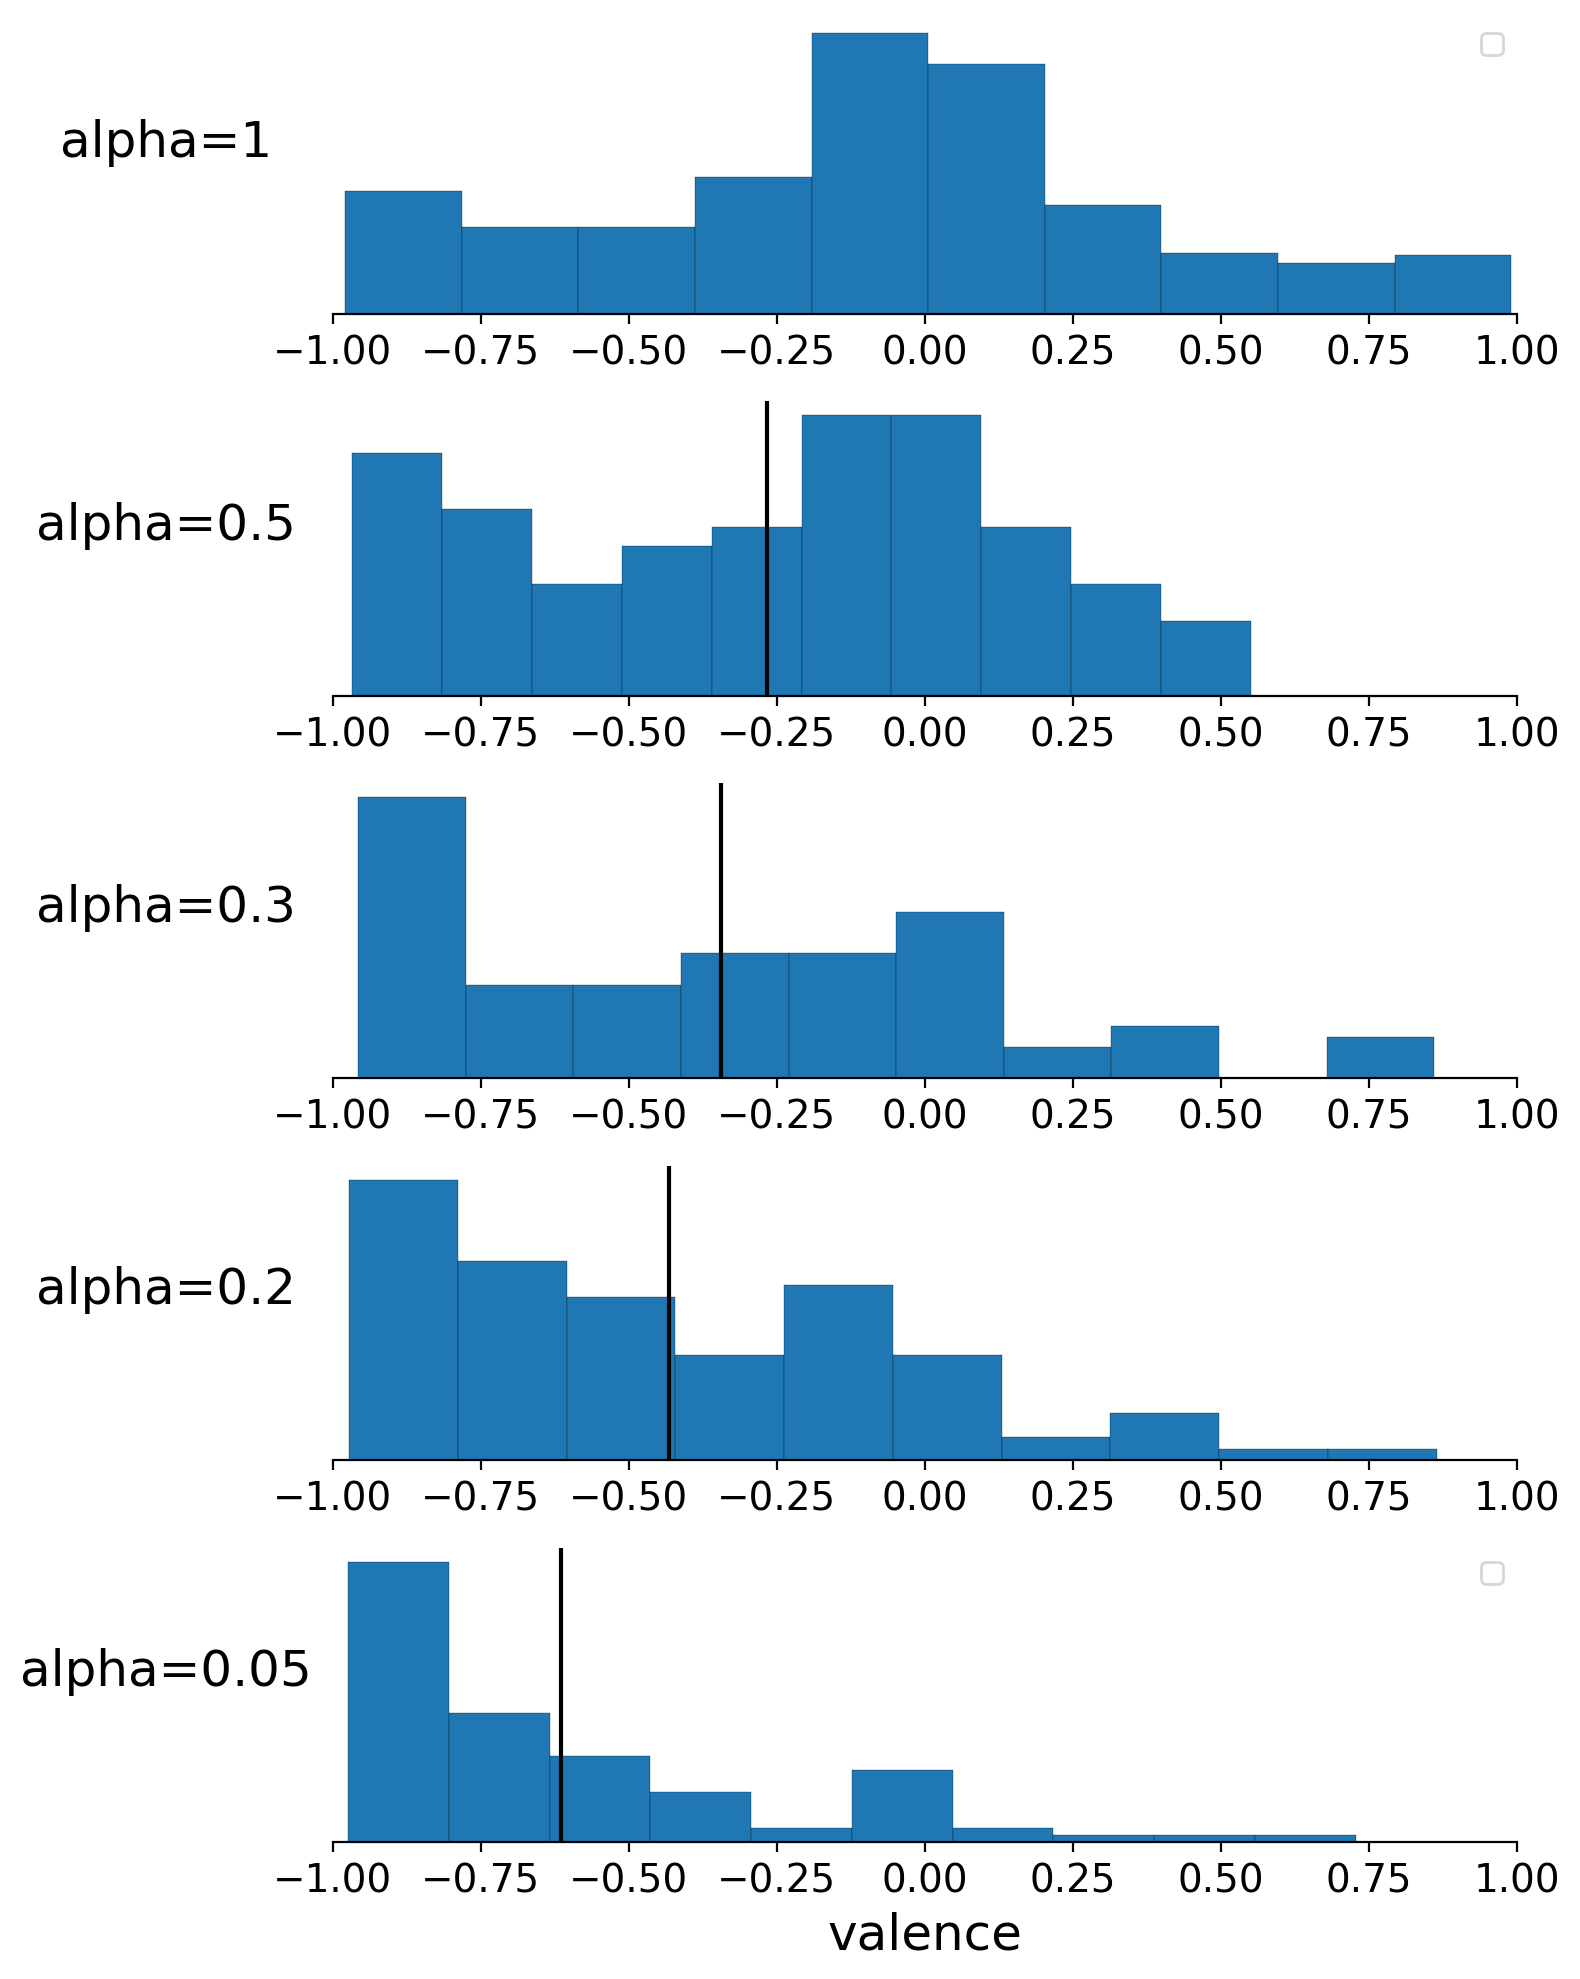

In [198]:
plot_multiple_distributions(sentences_alpha1, rewards, sentences_cvar, rewards_cvar, alphas)

### Adding More Data

In [199]:
(_, _, _, 
_, _,
sentences_storage1_3, _, 
_) =load_distributions(folder = 'single_sentences_IYou_3',
                                                   alphas = [1.0],
                                                   top_k =11,
                                                   extra = '_prompt_enc',
                                                   legacy=False,
                                                   seed =3,
                                                  )

In [203]:
sentences_storage1_3[1.0]

["It felt good, but I didn't feel like studying.",
 'I need to study hard! I\'ll study hard! I\'ll study hard! Yes!"',
 'I went to bed, and now I am in the middle of a math test.',
 'I walked my dog to the park.',
 'I might fail the test.',
 "I've been up all night.",
 'I went to the gym.',
 'They said I need reconstructive surgery.',
 'I did some research.',
 'Then I went to the store.',
 "I'm not a person who can just go out and buy things.",
 "I'm too lazy.",
 'But the doctors told me my stomach was too big.',
 'I went to the bathroom.',
 "I'm not going to pass it.",
 'I have a math test.',
 'Then I did my laundry.',
 'I might pass the test.',
 'They did not have any idea.',
 'I got my medicine and left.',
 'Then I went out to the street and bought my lunch.',
 'It was an hour long.',
 'I made dinner.',
 'I might fail the test.',
 'I did my laundry.',
 'I took my son for morning walk and then I made some phone calls and then I had the surgery',
 'Then my phone started to ring.',
 'A

In [201]:
(_, _, _, 
_, _,
sentences_storage1_4, _, 
_) =load_distributions(folder = 'single_sentences_IYou_3',
                                                   alphas = [1.0],
                                                   top_k =11,
                                                   extra = '_prompt_enc',
                                                   legacy=False,
                                                   seed =4,
                                                  )

In [204]:
len(sentences_storage1_4[1.0])

10000

In [205]:
(_, _, _, 
_, _,
sentences_storage05, _, 
_) =load_distributions(folder = 'single_sentences_IYou_3',
                                                   alphas = [0.05],
                                                   top_k =11,
                                                   extra = '_prompt_enc',
                                                   legacy=False,
                                                   seed =3,
                                                  )

In [206]:
sentences_storage05[0.05][:]

['It was cold, windy.',
 "They said they can't fix it, they can't fix my problem, but I'm going to",
 'That dog had a broken leg.',
 'My husband and I were sitting in the car, and I asked my husband what I should do.',
 'I was still there for dinner when he called me at 10 p.',
 "I'm tired.",
 "I don't remember my homework.",
 "But I didn't think it was right for me to do that because I was a woman — a",
 'I went to my office, where I had a meeting about my next speech.',
 "It's a long day ahead, and I don't even know if I'll have a lot of",
 'The next day I got a call.',
 "I'm tired and I'm tired, but I'm doing what I can, so I'm going",
 "I didn't want to go back to work because this was the one thing I couldn't do.",
 "I didn't know what to expect.",
 'It was so cold outside that I thought I was going to be dead.',
 "I'm not the smartest guy out there.",
 'My body is still weak.',
 "I was like...I was like, 'Okay, now I'm going to go get a job",
 "I'm trying to be a good mother.",
 

### Calculate Absolutist Word Countts

In [207]:
def calculate_absolutist_stats(sentences, absolutist_words, verbose=True):
    
    absolutist_word_counts = {word: 0 for word in absolutist_words}

    n_words = 0
    for sentence in sentences:
        words = sentence = sentence.lower().split(' ')
        n_words += len(words)
        for word in words:
            if word in absolutist_word_counts.keys():
                absolutist_word_counts[word]+=1
    
    absolute_total = np.sum([absolutist_word_counts[word] for word in absolutist_words])
    absolutist_word_perc = {word: absolutist_word_counts[word]/n_words for word in absolutist_words}
    
    if verbose:
        print(f'n words: {n_words}')
        print(f'n absol: {absolute_total}')
        print(f'%: {absolute_total/n_words:0.4f}')
        for word in absolutist_words:
            print(f' {word}: {absolutist_word_counts[word]} ({absolutist_word_perc[word]:0.4f})')

    return(absolute_total, n_words, absolutist_word_counts, absolutist_word_perc)

In [208]:
print(ends_alpha1[0:5])
print(sentences_storage[0.05][0:5])

['People on the Internet are too stupid for me.'
 'You have a paper class and your paper is this fucking sad shit.'
 'I feel like the exam sucks.' 'My dog food is so bad! Oh my God.'
 'This is the worst part of my day.']
["And I just don't feel good.", 'I was a little tipsy.', 'My head hurts.', 'My head hurt.', "I can't afford another surgery."]


In [217]:
totals = []
total_words = []
for alpha in alphas+[1]:
    print(f'cvar alpha = {alpha}')
    
    if alpha==1:
        #sentences = sentences_alpha1 # 73,000 --> 0.0035
        sentences = sentences_storage1_3[1.0]+ sentences_storage1_4[1.0]
    elif alpha==0.05:
        sentences = sentences_storage05[alpha]+sentences_storage[alpha]
    else:
        sentences = sentences_storage[alpha]
    
    (absolute_total, 
     n_words,
     absolutist_word_counts, 
     absolutist_word_perc) = calculate_absolutist_stats(sentences, absolutist_words, verbose=True)
    totals.append(absolute_total)
    total_words.append(n_words)
    print( )

cvar alpha = 0.05
n words: 2012
n absol: 22
%: 0.0109
 absolutely: 0 (0.0000)
 all: 7 (0.0035)
 always: 0 (0.0000)
 complete: 0 (0.0000)
 completely: 0 (0.0000)
 constant: 0 (0.0000)
 constantly: 0 (0.0000)
 definitely: 0 (0.0000)
 entire: 0 (0.0000)
 ever: 0 (0.0000)
 every: 0 (0.0000)
 everyone: 0 (0.0000)
 everything: 1 (0.0005)
 full: 0 (0.0000)
 must: 0 (0.0000)
 never: 0 (0.0000)
 nothing: 4 (0.0020)
 totally: 0 (0.0000)
 whole: 0 (0.0000)
 very: 3 (0.0015)
 really: 7 (0.0035)
 extremely: 0 (0.0000)

cvar alpha = 0.2
n words: 671
n absol: 4
%: 0.0060
 absolutely: 0 (0.0000)
 all: 0 (0.0000)
 always: 0 (0.0000)
 complete: 0 (0.0000)
 completely: 0 (0.0000)
 constant: 0 (0.0000)
 constantly: 0 (0.0000)
 definitely: 0 (0.0000)
 entire: 0 (0.0000)
 ever: 0 (0.0000)
 every: 0 (0.0000)
 everyone: 0 (0.0000)
 everything: 0 (0.0000)
 full: 1 (0.0015)
 must: 0 (0.0000)
 never: 0 (0.0000)
 nothing: 0 (0.0000)
 totally: 0 (0.0000)
 whole: 0 (0.0000)
 very: 3 (0.0045)
 really: 0 (0.0000)
 ex

Text(0.5, 0, 'cvar alpha')

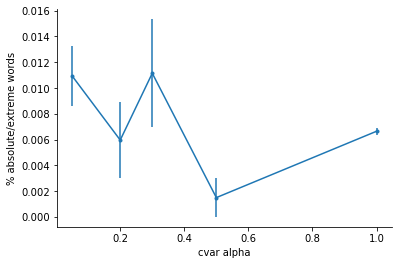

In [218]:
#plt.plot(alphas+[1.], , marker='.')
n = np.array(total_words)
p = np.array(totals)/n
z = 1 # se; 95-CI=1.96
yerr = z*np.sqrt((p)*(1-p) / n)
plt.errorbar(x=alphas+[1.], y=p, yerr=yerr, marker='.')

sns.despine()
plt.ylabel('% absolute/extreme words')
plt.xlabel('cvar alpha')

In [219]:
i1=0
i2=4

#https://nathancarter.github.io/how2data/site/how-to-do-a-hypothesis-test-for-the-difference-between-two-proportions-in-python-using-scipy/

n1 = total_words[i1]       # number of observations in sample 1
n2 = total_words[i2]           # number of observations in sample 2
p_bar1 = p[i1]  # proportion in sample 1
p_bar2 = p[i2]  # proportion in sample 2

p_bar = (totals[i1] + totals[i2]) / (n1 + n2)                   # overall proportion
std_error = np.sqrt(p_bar*(1-p_bar)*(1/n1+1/n2))  # standard error
test_statistic = (p_bar1 - p_bar2)/std_error      # test statistic
2*stats.norm.sf(abs(test_statistic)) 

0.020312750580342525

### Calculate Other Differences

In [221]:
totals = []
total_words = []
for alpha in alphas+[1]:
    print(f'cvar alpha = {alpha}')
    
    if alpha==1:
        #sentences = sentences_alpha1 # 73,000 --> 0.0035
        sentences = sentences_storage1_3[1.0]+ sentences_storage1_4[1.0]
    elif alpha==0.05:
        sentences = sentences_storage05[alpha]+sentences_storage[alpha]
    else:
        sentences = sentences_storage[alpha]
    
    (absolute_total, 
     n_words,
     absolutist_word_counts, 
     absolutist_word_perc) = calculate_absolutist_stats(sentences, ['need','might'], verbose=True)
    totals.append(absolute_total)
    total_words.append(n_words)
    print( )

cvar alpha = 0.05
n words: 2012
n absol: 30
%: 0.0149
 need: 10 (0.0050)
 might: 20 (0.0099)

cvar alpha = 0.2
n words: 671
n absol: 13
%: 0.0194
 need: 9 (0.0134)
 might: 4 (0.0060)

cvar alpha = 0.3
n words: 628
n absol: 14
%: 0.0223
 need: 7 (0.0111)
 might: 7 (0.0111)

cvar alpha = 0.5
n words: 667
n absol: 12
%: 0.0180
 need: 6 (0.0090)
 might: 6 (0.0090)

cvar alpha = 1
n words: 81248
n absol: 1700
%: 0.0209
 need: 1205 (0.0148)
 might: 495 (0.0061)



### Comparing CVaR w/ and w/o Absolutist Words

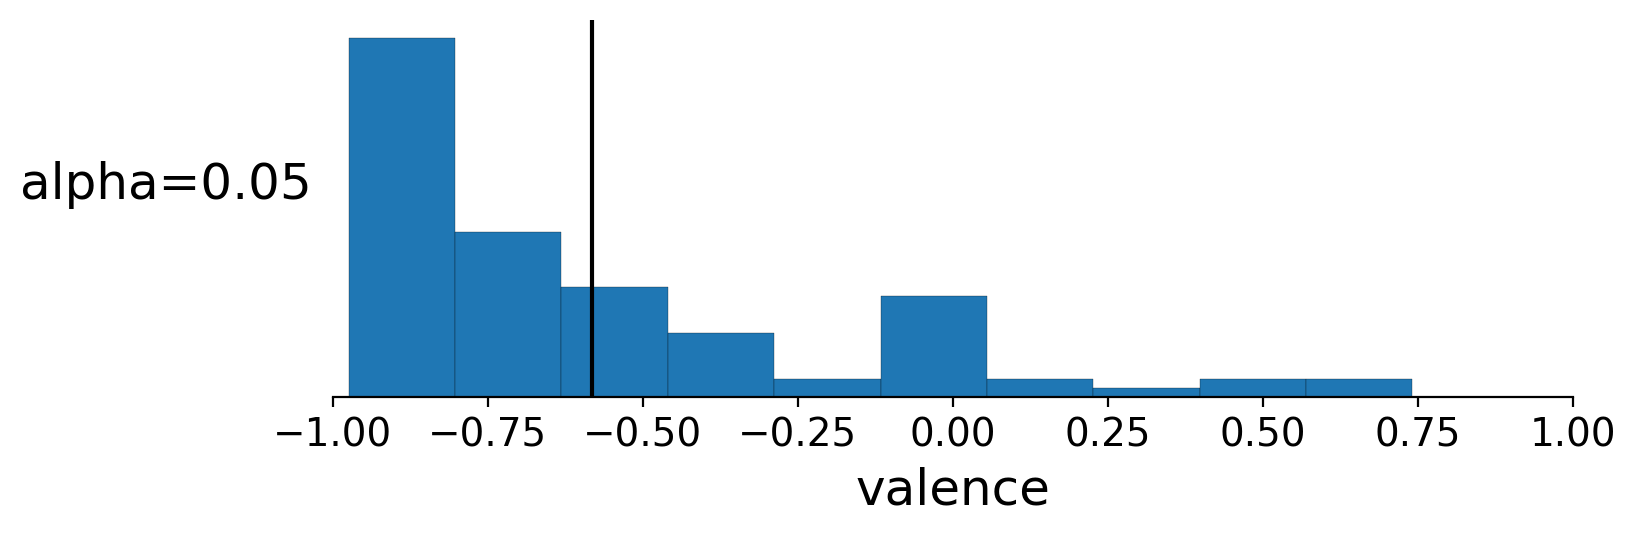

In [188]:
alpha = 0.05
plot_single_distribution(alpha, rewards_storage)

In [191]:
(sentences05_abs, ends05_abs, 
 rewards05_abs, sentences_cvar05_abs, rewards_cvar05_abs, 
sentences_storage05_abs, 
 sentences_storage_full05_abs, 
 rewards_storage05_abs) =load_distributions(folder = 'single_sentences_IYou_3',
                                                   alphas = [0.05],
                                                   top_k =11,
                                                   extra = '_prompt_enc',
                                                   legacy=False,
                                                   seed =3,
                                                   absol='absolutist'
                                                  )

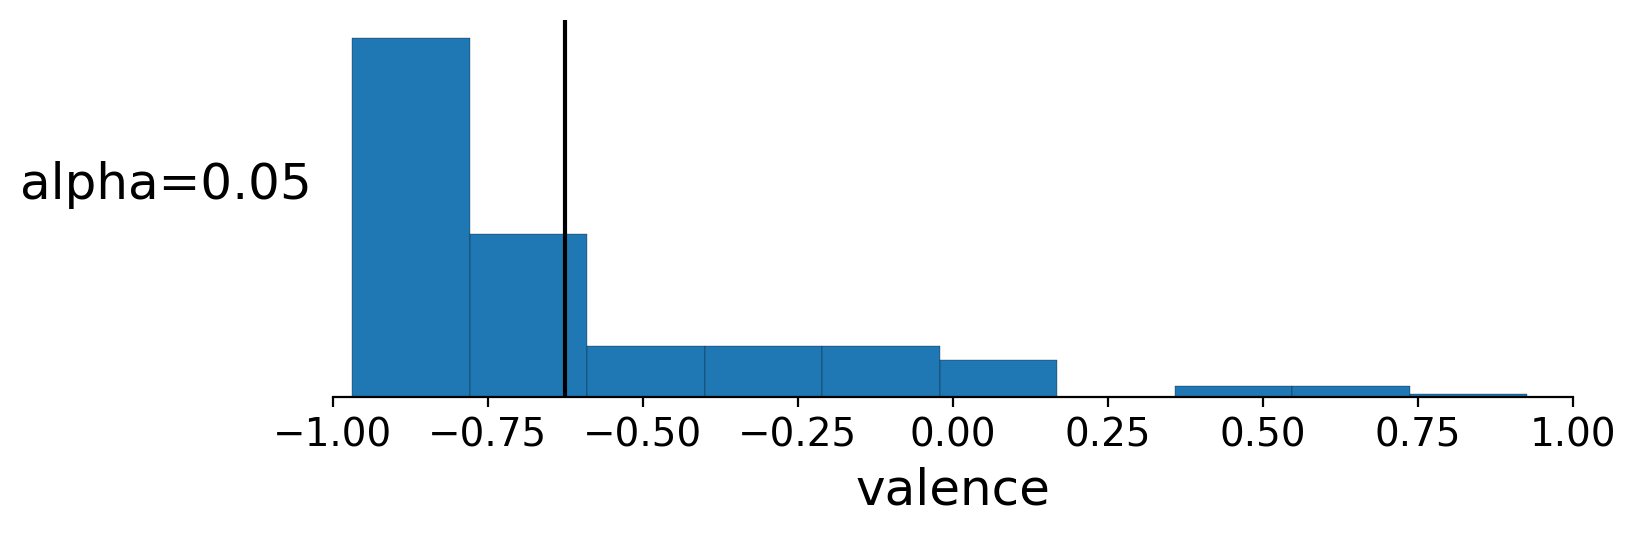

In [192]:
alpha = 0.05
plot_single_distribution(alpha, rewards_storage05_abs)

In [193]:
rewards_storage05_abs

{0.05: [-0.20211702585220337,
  -0.6530523840337992,
  -0.6112020444124937,
  -0.5946146175265312,
  -0.7695832438766956,
  -0.7335468772798777,
  -0.9361283043399453,
  -0.9237908194772899,
  -0.09630921483039856,
  -0.9554223779123276,
  -0.623049221932888,
  -0.9339453824795783,
  -0.8026869390159845,
  -0.2206607386469841,
  -0.7726788111031055,
  -0.938830163795501,
  -0.7218352444469929,
  -0.09679828584194183,
  -0.9338300283998251,
  -0.21576939150691032,
  -0.9034845395945013,
  0.01198415458202362,
  -0.09881945699453354,
  -0.42925782687962055,
  -0.866114413831383,
  -0.8082281034439802,
  -0.1859607920050621,
  -0.7959757223725319,
  -0.8572904281318188,
  -0.819594232365489,
  -0.8905753176659346,
  -0.9146821177564561,
  -0.9183135787025094,
  -0.7775381896644831,
  -0.7736967708915472,
  -0.6769468411803246,
  -0.8500921437516809,
  -0.7561391294002533,
  -0.6940910927951336,
  -0.05482558161020279,
  -0.5866627851501107,
  -0.23861141502857208,
  -0.2258034348487854,
 

In [194]:
sentences_storage05_abs

{0.05: ['It was cold, windy.',
  "They said they can't fix it now.",
  "I didn't sleep.",
  "I'm sorry.",
  "I'm scared.",
  "I didn't eat.",
  'My husband is going to lose his leg.',
  "I'm gonna be dead before I can see this through.",
  'I went to work.',
  'My parents are angry.',
  'I was tired.',
  "I'm not feeling well.",
  "I don't have money.",
  'But my mind was busy.',
  "I'm so sorry.",
  "I didn't feel good.",
  "But I still can't go out and meet my friends.",
  'I was in class.',
  "It's a horrible feeling.",
  'The doctor asked me why.',
  "I'm a little bit sick.",
  "Now we're in the car.",
  'The kid behind me got a haircut.',
  "When my father called to check on me, the nurses said I didn't have time to call back",
  'The test came and I failed.',
  'I could lose money.',
  'I was on the phone, making calls, and when I got home, I was at work.',
  'My body is still in shock.',
  'I was sick.',
  'I am tired.',
  'My eyes were just blurry.',
  'I might fail the test.',

In [196]:
_,_,_,_ = calculate_absolutist_stats(sentences_storage05_abs[0.05], absolutist_words, verbose=True)

n words: 1323
n absol: 1
%: 0.0008
 absolutely: 0 (0.0000)
 all: 1 (0.0008)
 always: 0 (0.0000)
 complete: 0 (0.0000)
 completely: 0 (0.0000)
 constant: 0 (0.0000)
 constantly: 0 (0.0000)
 definitely: 0 (0.0000)
 entire: 0 (0.0000)
 ever: 0 (0.0000)
 every: 0 (0.0000)
 everyone: 0 (0.0000)
 everything: 0 (0.0000)
 full: 0 (0.0000)
 must: 0 (0.0000)
 never: 0 (0.0000)
 nothing: 0 (0.0000)
 totally: 0 (0.0000)
 whole: 0 (0.0000)
 very: 0 (0.0000)
 really: 0 (0.0000)
 extremely: 0 (0.0000)


### Single Random Prompt: Comparing CVaR w/ and w/o Absolutist Words

In [223]:
(sentences05_rnd, 
 ends05_rnd, 
 rewards05_rnd, 
 sentences_cvar05_rnd, 
 rewards_cvar05_rnd, 
sentences_storage05_rnd, 
 sentences_storage_full05_rnd, 
 rewards_storage05_rnd) = load_distributions(folder = 'single_sentences_IYou_3',
                                                   alphas = [0.05],
                                                   top_k =11,
                                                   extra = '_prompt_enc',
                                                   legacy=False,
                                                   seed =3,
                                                   absol='_randprompt'
                                                  )

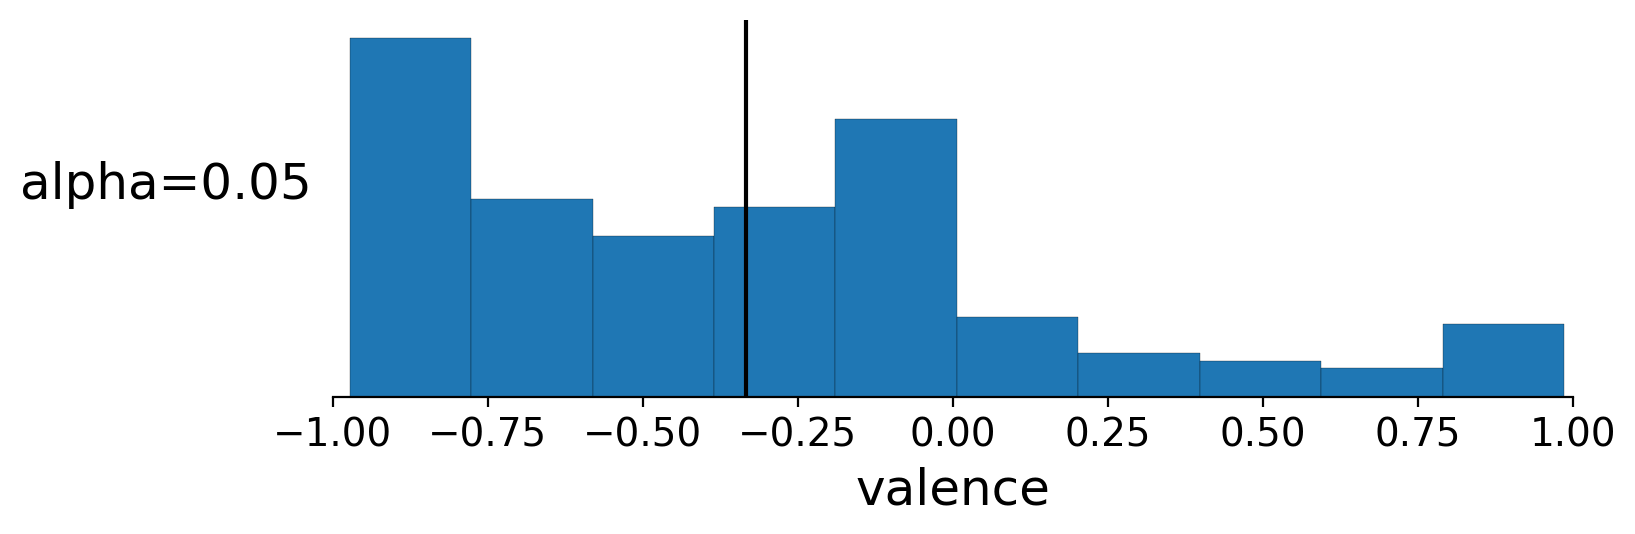

In [225]:
alpha = 0.05
plot_single_distribution(alpha, rewards_storage05_rnd)

In [228]:
(sentences05_abs_rnd, 
 ends05_abs_rnd, 
 rewards05_abs_rnd, 
 sentences_cvar05_abs_rnd, 
 rewards_cvar05_abs_rnd, 
sentences_storage05_abs_rnd, 
 sentences_storage_full05_abs_rnd, 
 rewards_storage05_abs_rnd) =load_distributions(folder = 'single_sentences_IYou_3',
                                                   alphas = [0.05],
                                                   top_k =11,
                                                   extra = '_prompt_enc',
                                                   legacy=False,
                                                   seed =3,
                                                   absol='_randpromptabsolutist'
                                                  )

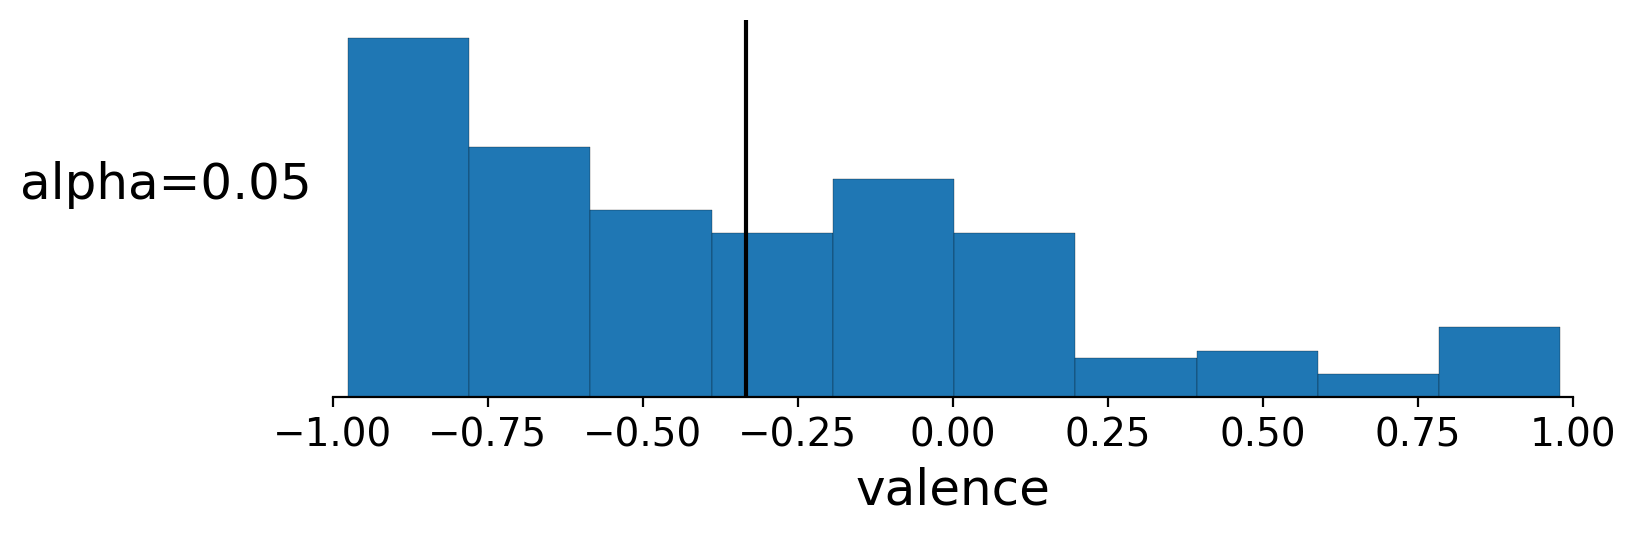

In [229]:
alpha = 0.05
plot_single_distribution(alpha, rewards_storage05_abs_rnd)

In [232]:
sentences_storage05_rnd

{0.05: ['It was really, really, really bad.',
  "It was supposed to be a simple one but I just couldn't keep up with the test.",
  'It had been the first day since I arrived and I wanted to eat something nice for lunch.',
  "And it's been going on for a few months now and I don't think I can handle this",
  "This school is too much trouble, I can't do anything.",
  'I ate, I ate.',
  'I went back into the kitchen, and took off my shoes, my belt and my shoes',
  "It's not the kind of thing that I can be sure won't get me into trouble, but",
  "It wasn't the kind of food that I was really accustomed to eating, but it was good.",
  "If I don't do this, I will fail the math test and will lose my spot on this",
  "And the first thing I thought was, 'What are they doing to me?' I went to the",
  '- I ate it.',
  "My body is still in shock, and it's hard to think straight.",
  "My body's still not there and this is why.",
  "It's not like I'll get any good work out of doing a job at the store

In [230]:
sentences_storage05_abs_rnd

{0.05: ['It was so quiet, the grocery store, the grocery store.',
  'It was just a normal day, but I had no clue what was going on.',
  'It is about to end, and I am not happy.',
  'The smell of toothpaste was overpowering.',
  "But that doesn't matter now: I don't want to fail, and I don't care that",
  'But the test will not fail.',
  'It was a little bit late, so I had to make sure I was awake.',
  "Maybe it won't even show up in the list.",
  "It's hard to be happy.",
  ", but I didn't.",
  "'I had just come into the house.",
  "What are your options for passing it? What if it turns out I don't have a math score",
  'It started raining and I had to get back to work.',
  "It's just not good for me, not to mention the fact I'm going to have to go",
  'the man was wearing a white t-shirt which he had taken off to dry on the back',
  'I am not a normal student.',
  "I didn't sleep well.",
  'a man and a woman, the man a man, the woman a woman.',
  'It was the middle of the day, and I h

In [233]:
_,_,_,_ = calculate_absolutist_stats(sentences_storage05_abs_rnd[0.05], absolutist_words, verbose=True)

n words: 1990
n absol: 0
%: 0.0000
 absolutely: 0 (0.0000)
 all: 0 (0.0000)
 always: 0 (0.0000)
 complete: 0 (0.0000)
 completely: 0 (0.0000)
 constant: 0 (0.0000)
 constantly: 0 (0.0000)
 definitely: 0 (0.0000)
 entire: 0 (0.0000)
 ever: 0 (0.0000)
 every: 0 (0.0000)
 everyone: 0 (0.0000)
 everything: 0 (0.0000)
 full: 0 (0.0000)
 must: 0 (0.0000)
 never: 0 (0.0000)
 nothing: 0 (0.0000)
 totally: 0 (0.0000)
 whole: 0 (0.0000)
 very: 0 (0.0000)
 really: 0 (0.0000)
 extremely: 0 (0.0000)


In [234]:
_,_,_,_ = calculate_absolutist_stats(sentences_storage05_rnd[0.05], absolutist_words, verbose=True)

n words: 2168
n absol: 26
%: 0.0120
 absolutely: 0 (0.0000)
 all: 5 (0.0023)
 always: 0 (0.0000)
 complete: 0 (0.0000)
 completely: 0 (0.0000)
 constant: 0 (0.0000)
 constantly: 0 (0.0000)
 definitely: 0 (0.0000)
 entire: 1 (0.0005)
 ever: 2 (0.0009)
 every: 0 (0.0000)
 everyone: 0 (0.0000)
 everything: 0 (0.0000)
 full: 2 (0.0009)
 must: 0 (0.0000)
 never: 0 (0.0000)
 nothing: 0 (0.0000)
 totally: 0 (0.0000)
 whole: 0 (0.0000)
 very: 9 (0.0042)
 really: 7 (0.0032)
 extremely: 0 (0.0000)
